## Very Hardware:

- #### **CPU**: Intel i5-12600KF
- #### **GPU**: Nvidia RTX 4070 Ti OC
- #### **RAM**: 2x16 GB DDR4 3600
- #### **MOBO**: Z690 MSI Tomahawk DDR4

### 🚧 Helper function 🔨 

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
%matplotlib inline

def mandelbrot_image(xmin, xmax, ymin, ymax, width=3, height=3, maxiter=80, cmap='hot'):
    """
    Generate and display a Mandelbrot fractal image.

    Parameters:
    xmin (float): The minimum x-coordinate of the fractal region.
    xmax (float): The maximum x-coordinate of the fractal region.
    ymin (float): The minimum y-coordinate of the fractal region.
    ymax (float): The maximum y-coordinate of the fractal region.
    width (float, optional): The width of the output image in inches. Defaults to 3.
    height (float, optional): The height of the output image in inches. Defaults to 3.
    maxiter (int, optional): The maximum number of iterations for the Mandelbrot algorithm. Defaults to 80.
    cmap (str, optional): The colormap to use for the image. Defaults to 'hot'.

    Returns:
    None
    """
    dpi = 72
    img_width = dpi * width
    img_height = dpi * height
    x, y, z = mandelbrot_set(xmin, xmax, ymin, ymax, img_width, img_height, maxiter)

    fig, ax = plt.subplots(figsize=(width, height), dpi=72)
    ticks = np.arange(0, img_width, 3 * dpi)
    x_ticks = xmin + (xmax - xmin) * ticks / img_width
    plt.xticks(ticks, x_ticks)
    y_ticks = ymin + (ymax - ymin) * ticks / img_width
    plt.yticks(ticks, y_ticks)

    norm = colors.PowerNorm(0.3)
    ax.imshow(z.T, cmap=cmap, origin='lower', norm=norm)
def mandelbrot_image(xmin,xmax,ymin,ymax,width=3,height=3,maxiter=80,cmap='hot'):
    dpi = 72
    img_width = dpi * width
    img_height = dpi * height
    x,y,z = mandelbrot_set(xmin,xmax,ymin,ymax,img_width,img_height,maxiter)
    
    fig, ax = plt.subplots(figsize=(width, height),dpi=72)
    ticks = np.arange(0,img_width,3*dpi)
    x_ticks = xmin + (xmax-xmin)*ticks/img_width
    plt.xticks(ticks, x_ticks)
    y_ticks = ymin + (ymax-ymin)*ticks/img_width
    plt.yticks(ticks, y_ticks)
    
    norm = colors.PowerNorm(0.3)
    ax.imshow(z.T,cmap=cmap,origin='lower',norm=norm) 



In [2]:
from __future__ import absolute_import
from __future__ import print_function

import pyopencl as cl


In [3]:
%load_ext pyopencl.ipython_ext

## Fancy ✨_choose device_✨ time:

In [32]:
ctx = cl.create_some_context(interactive=True)
devices = ctx.get_info(cl.context_info.DEVICES)
print(devices)

Choose platform:
[0] <pyopencl.Platform 'Portable Computing Language' at 0x7d93755f5008>
Choose device(s):
[0] <pyopencl.Device 'cpu-haswell-12th Gen Intel(R) Core(TM) i5-12600KF' on 'Portable Computing Language' at 0x5a8f76722020>
[1] <pyopencl.Device 'NVIDIA GeForce RTX 4070 Ti' on 'Portable Computing Language' at 0x5a8f767224a0>
Set the environment variable PYOPENCL_CTX=':0' to avoid being asked again.
[<pyopencl.Device 'cpu-haswell-12th Gen Intel(R) Core(TM) i5-12600KF' on 'Portable Computing Language' at 0x5a8f76722020>]


# Blue power! ☄️ 

In [40]:
def mandelbrot_gpu(q, maxiter):
    """
    Calculates the Mandelbrot set using GPU acceleration.

    Parameters:
    - q: numpy.ndarray
        Array of complex numbers representing the points in the complex plane.
    - maxiter: int
        Maximum number of iterations for each point.

    Returns:
    - output: numpy.ndarray
        Array of integers representing the number of iterations for each point to escape the Mandelbrot set.
    """

    global ctx
    
    queue = cl.CommandQueue(ctx)
    
    output = np.empty(q.shape, dtype=np.uint16)

    prg = cl.Program(ctx, """
    #pragma OPENCL EXTENSION cl_khr_byte_addressable_store : enable
    __kernel void mandelbrot(__global float2 *q,
                     __global ushort *output, ushort const maxiter)
    {
        int gid = get_global_id(0);
        float nreal, real = 0;
        float imag = 0;
        output[gid] = 0;
        for(int curiter = 0; curiter < maxiter; curiter++) {
            nreal = real*real - imag*imag + q[gid].x;
            imag = 2* real*imag + q[gid].y;
            real = nreal;
            if (real*real + imag*imag > 4.0f){
                 output[gid] = curiter;
                 break;
            }
        }
    }
    """).build()

    mf = cl.mem_flags
    q_opencl = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=q)
    output_opencl = cl.Buffer(ctx, mf.WRITE_ONLY, output.nbytes)


    prg.mandelbrot(queue, output.shape, None, q_opencl,
                   output_opencl, np.uint16(maxiter))

    cl.enqueue_copy(queue, output, output_opencl).wait()
    
    return output

def mandelbrot_set1(xmin, xmax, ymin, ymax, width, height, maxiter):
    """
    Generate the Mandelbrot set using GPU acceleration.

    Parameters:
    xmin (float): The minimum x-coordinate of the plot.
    xmax (float): The maximum x-coordinate of the plot.
    ymin (float): The minimum y-coordinate of the plot.
    ymax (float): The maximum y-coordinate of the plot.
    width (int): The width of the plot in pixels.
    height (int): The height of the plot in pixels.
    maxiter (int): The maximum number of iterations for the Mandelbrot algorithm.

    Returns:
    tuple: A tuple containing the x-coordinates, y-coordinates, and the Mandelbrot set as a 2D array.
    """
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:, None] * 1j
    c = np.ravel(c)
    n3 = mandelbrot_gpu(c, maxiter)
    n3 = n3.reshape((width, height))
    return (r1, r2, n3.T)
def mandelbrot_set1(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    c = np.ravel(c)
    n3 = mandelbrot_gpu(c,maxiter)
    n3 = n3.reshape((width,height))
    return (r1,r2,n3.T)

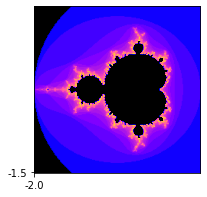

In [41]:
mandelbrot_set = mandelbrot_set1
mandelbrot_image(-2.0,1.0,-1.5,1.5,cmap='gnuplot2')

In [53]:
%timeit mandelbrot_set3(-2.0,1.0,-1.5,1.5,5000,5000,100)

228 ms ± 9.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# GO GO Team GREEN! 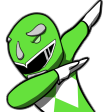
## GpuMaxxin

In [30]:
def mandelbrot_gpu(q, maxiter):
    """
    Calculates the Mandelbrot set using GPU acceleration.

    Parameters:
    - q (numpy.ndarray): Array of complex numbers representing the points in the complex plane.
    - maxiter (int): Maximum number of iterations to perform.

    Returns:
    - numpy.ndarray: Array of integers representing the number of iterations taken to escape the Mandelbrot set for each point.
    """

    global ctx
    
    queue = cl.CommandQueue(ctx)
    
    output = np.empty(q.shape, dtype=np.uint16)

    prg = cl.Program(ctx, """
    #pragma OPENCL EXTENSION cl_khr_byte_addressable_store : enable
    __kernel void mandelbrot(__global float2 *q,
                     __global ushort *output, ushort const maxiter)
    {
        int gid = get_global_id(0);
        float real = q[gid].x;
        float imag = q[gid].y;
        output[gid] = 0;
        for(int curiter = 0; curiter < maxiter; curiter++) {
            float real2 = real*real, imag2 = imag*imag;
            if (real*real + imag*imag > 4.0f){
                 output[gid] = curiter;
                 return;
            }
            imag = 2* real*imag + q[gid].y;
            real = real2 - imag2 + q[gid].x;
            
        }
    }
    """).build()

    mf = cl.mem_flags
    q_opencl = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=q)
    output_opencl = cl.Buffer(ctx, mf.WRITE_ONLY, output.nbytes)


    prg.mandelbrot(queue, output.shape, None, q_opencl,
                   output_opencl, np.uint16(maxiter))

    cl.enqueue_copy(queue, output, output_opencl).wait()
    
    return output

def mandelbrot_set2(xmin, xmax, ymin, ymax, width, height, maxiter):
    """
    Generate the Mandelbrot set using GPU acceleration.

    Parameters:
    xmin (float): The minimum x-coordinate of the plot.
    xmax (float): The maximum x-coordinate of the plot.
    ymin (float): The minimum y-coordinate of the plot.
    ymax (float): The maximum y-coordinate of the plot.
    width (int): The width of the plot in pixels.
    height (int): The height of the plot in pixels.
    maxiter (int): The maximum number of iterations to compute.

    Returns:
    tuple: A tuple containing the x-coordinates, y-coordinates, and the Mandelbrot set as a 2D array.
    """
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:, None] * 1j
    c = np.ravel(c)
    n3 = mandelbrot_gpu(c, maxiter)
    n3 = n3.reshape((width, height))
    return (r1, r2, n3.T)
def mandelbrot_set2(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    c = np.ravel(c)
    n3 = mandelbrot_gpu(c,maxiter)
    n3 = n3.reshape((width,height))
    return (r1,r2,n3.T)

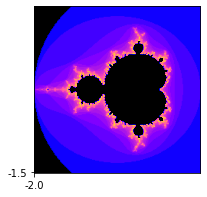

In [36]:
mandelbrot_set = mandelbrot_set2
mandelbrot_image(-2.0,1.0,-1.5,1.5,cmap='gnuplot2')

In [56]:
%timeit mandelbrot_set2(-2.0,1.0,-1.5,1.5,5000,5000,100)

118 ms ± 908 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Tests 🧪

In [63]:
import unittest


class TestMandelbrotSet(unittest.TestCase):
    """
    A test case for the Mandelbrot set generation.
    """

    def test_dimensions(self):
        # Test if the dimensions of the returned arrays match the input dimensions
        xmin, xmax, ymin, ymax = -2, 2, -2, 2
        width, height = 100, 100
        maxiter = 100
        x_coords, y_coords, mandelbrot = mandelbrot_set2(xmin, xmax, ymin, ymax, width, height, maxiter)
        
        self.assertEqual(len(x_coords), width)
        self.assertEqual(len(y_coords), height)
        self.assertEqual(mandelbrot.shape, (width, height))
    
    def test_maxiter(self):
        # Test if increasing maxiter gives more detailed output
        xmin, xmax, ymin, ymax = -2, 2, -2, 2
        width, height = 100, 100
        maxiter1 = 100
        maxiter2 = 200
        
        _, _, mandelbrot1 = mandelbrot_set2(xmin, xmax, ymin, ymax, width, height, maxiter1)
        _, _, mandelbrot2 = mandelbrot_set2(xmin, xmax, ymin, ymax, width, height, maxiter2)
        
        self.assertTrue(np.sum(mandelbrot2 != mandelbrot1) > 0)
        
    def test_specific_point(self):
        # Test if a specific point is in the Mandelbrot set
        xmin, xmax, ymin, ymax = -2, 2, -2, 2
        width, height = 100, 100
        maxiter = 100
        
        x_coords, y_coords, mandelbrot = mandelbrot_set2(xmin, xmax, ymin, ymax, width, height, maxiter)
        
        # Test if the center of the plot is in the Mandelbrot set
        center_index_x = width // 2
        center_index_y = height // 2
        center_point = mandelbrot[center_index_x, center_index_y]
        
        self.assertEqual(center_point, 0)

# Run the tests
unittest.main(argv=[''], verbosity=2, exit=False)

test_dimensions (__main__.TestMandelbrotSet.test_dimensions) ... ok
test_maxiter (__main__.TestMandelbrotSet.test_maxiter) ... ok
test_specific_point (__main__.TestMandelbrotSet.test_specific_point) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.033s

OK


### 💾 Memory Talk:

- **Global Memory**:
    - Arrays q and output are stored in global memory (__global qualifier).
    - OpenCL buffers q_opencl and output_opencl are created from q and output arrays, respectively, for kernel invocation.
- **Local Memory**:
    - No explicit usage of local memory; each work-item operates independently.
- **Private Memory**:
    - Private memory is implicitly used for variables declared within the kernel function (real, imag, nreal, curiter).
- **Constant Memory**:
    - There's no explicit usage of constant memory in this kernel; it's typically for read-only data shared across all work-items, which isn't required here.

Thank you for coming to my Memory Talk.

# 📣📣!!BONUS ROUND!!📣📣

### Numba ft. (Kid)CUDA - FastBoi [original mix]

_Restart your kernel if you plan to run this code with CUDA-enabled GPU_

In [1]:
from numba import cuda
from numba import *
import numpy as np
from pylab import imshow, show
from timeit import default_timer as timer


def mandel(x, y, max_iters):
  """
  Given the real and imaginary parts of a complex number,
  determine if it is a candidate for membership in the Mandelbrot
  set given a fixed number of iterations.

  Parameters:
  - x (float): The real part of the complex number.
  - y (float): The imaginary part of the complex number.
  - max_iters (int): The maximum number of iterations to perform.

  Returns:
  - int: The number of iterations performed before the complex number
         exceeded the threshold of 2, or the maximum number of iterations
         if the threshold was not exceeded.
  """
  c = x +  y*1j
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 2:
      return i

  return max_iters

mandel_gpu = cuda.jit(device=True)(mandel)

In [2]:
@cuda.jit
def mandel_kernel(min_x, max_x, min_y, max_y, image, iters):
  """
  Computes the Mandelbrot set using GPU parallelization.

  Args:
    min_x (float): The minimum x-coordinate of the region.
    max_x (float): The maximum x-coordinate of the region.
    min_y (float): The minimum y-coordinate of the region.
    max_y (float): The maximum y-coordinate of the region.
    image (ndarray): The image array to store the computed Mandelbrot set.
    iters (int): The maximum number of iterations for the Mandelbrot computation.

  Returns:
    None: The computed Mandelbrot set is stored in the `image` array.
  """
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

  startX, startY = cuda.grid(2)
  gridX = cuda.gridDim.x * cuda.blockDim.x;
  gridY = cuda.gridDim.y * cuda.blockDim.y;

  for x in range(startX, width, gridX):
    real = min_x + x * pixel_size_x
    for y in range(startY, height, gridY):
      imag = min_y + y * pixel_size_y 
      image[y, x] = mandel_gpu(real, imag, iters)

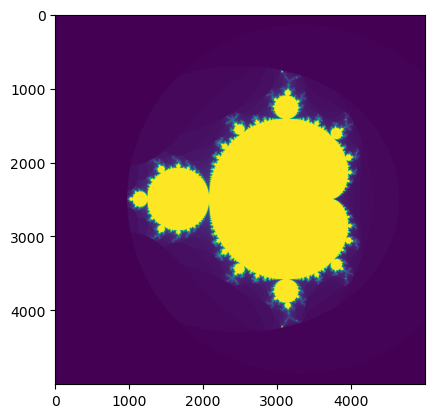

In [3]:


gimage = np.zeros((5000, 5000), dtype = np.uint8)
blockdim = (32, 8)
griddim = (32,16)

d_image = cuda.to_device(gimage)
mandel_kernel[griddim, blockdim](-2.0, 1.0, -1.5, 1.5, d_image, 100) 
d_image.copy_to_host()


imshow(d_image)
show()

### Sanity check: ✅

In [10]:
%timeit -r 7 -n 1 mandel_kernel[griddim, blockdim](-2.0, 1.0, -1.5, 1.5, d_image, 100) 

The slowest run took 13.02 times longer than the fastest. This could mean that an intermediate result is being cached.
66.7 µs ± 87.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# 🤯🤯I am speed.🤯🤯

# Benchmarks:

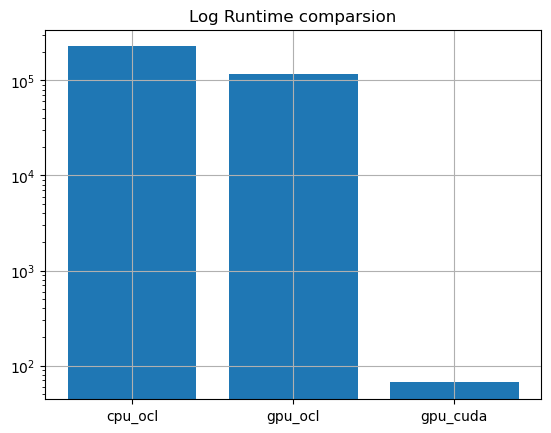

In [62]:
implementations = ["cpu_ocl", "gpu_ocl", "gpu_cuda"]
runtimes = [228000, 118000, 66.7]

plt.bar(implementations, runtimes, log=True)
plt.xticks(rotation=0)
plt.title("Log Runtime comparsion")
plt.grid()
plt.show()

### _A message to thee, noble reader_:
_Take heed, for the **y**-axis doth assume the guise of logarithmic, thus permitting the display of **gpu_cuda** upon the graph._